In [1]:
!pip install pandas numpy matplotlib seaborn

  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached numpy-2.4.1-cp313-cp313-macosx_14_0_arm64.whl.metadata (6.6 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl (10.7 MB)
Using cached numpy-2.4

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

# Set plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Data Loading

The dataset provides 4 versions based on annotator agreement levels:
- **AllAgree**: 100% agreement (highest quality)
- **75Agree**: >75% agreement
- **66Agree**: >66% agreement
- **50Agree**: >50% agreement (maximum data)

In [3]:
# Function to load and parse the dataset files
def load_phrasebank_data(filename):
    """Load a Financial Phrase Bank data file and return a DataFrame"""
    sentences = []
    sentiments = []

    with open(
        f"FinancialPhraseBank-v1.0/{filename}", "r", encoding="utf-8", errors="ignore"
    ) as f:
        for line in f:
            line = line.strip()
            if "@" in line:
                # Split on last @ to handle @ symbols in sentences
                parts = line.rsplit("@", 1)
                if len(parts) == 2:
                    sentences.append(parts[0])
                    sentiments.append(parts[1])

    df = pd.DataFrame({"sentence": sentences, "sentiment": sentiments})

    # Add text statistics
    df["char_length"] = df["sentence"].str.len()
    df["word_count"] = df["sentence"].str.split().str.len()

    return df


# Load all four versions
data_files = {
    "50% Agreement": "Sentences_50Agree.txt",
    "66% Agreement": "Sentences_66Agree.txt",
    "75% Agreement": "Sentences_75Agree.txt",
    "100% Agreement": "Sentences_AllAgree.txt",
}

datasets = {}
for name, filename in data_files.items():
    datasets[name] = load_phrasebank_data(filename)
    print(f"Loaded {name}: {len(datasets[name])} sentences")

Loaded 50% Agreement: 4846 sentences
Loaded 66% Agreement: 4217 sentences
Loaded 75% Agreement: 3453 sentences
Loaded 100% Agreement: 2264 sentences


## 2. Dataset Overview Statistics

In [4]:
# Create summary statistics table
summary_stats = []

for name, df in datasets.items():
    stats = {
        "Dataset": name,
        "Total Sentences": len(df),
        "Positive": (df["sentiment"] == "positive").sum(),
        "Negative": (df["sentiment"] == "negative").sum(),
        "Neutral": (df["sentiment"] == "neutral").sum(),
        "Avg Char Length": df["char_length"].mean(),
        "Avg Word Count": df["word_count"].mean(),
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.round(1)

print("\n" + "=" * 80)
print("DATASET OVERVIEW STATISTICS")
print("=" * 80)
display(summary_df)


DATASET OVERVIEW STATISTICS


,Dataset,Total Sentences,Positive,Negative,Neutral,Avg Char Length,Avg Word Count
0,50% Agreement,4846,1363,604,2879,128.1,23.1
1,66% Agreement,4217,1168,514,2535,127.2,23.0
2,75% Agreement,3453,887,420,2146,124.8,22.8
3,100% Agreement,2264,570,303,1391,121.9,22.4


## 3. Sentiment Distribution Analysis

In [5]:
# Create detailed sentiment distribution table with percentages
sentiment_dist = []

for name, df in datasets.items():
    total = len(df)
    for sentiment in ["positive", "negative", "neutral"]:
        count = (df["sentiment"] == sentiment).sum()
        sentiment_dist.append(
            {
                "Dataset": name,
                "Sentiment": sentiment.capitalize(),
                "Count": count,
                "Percentage": f"{(count / total) * 100:.2f}%",
            }
        )

sentiment_df = pd.DataFrame(sentiment_dist)
pivot_sentiment = sentiment_df.pivot(
    index="Dataset", columns="Sentiment", values="Count"
)

print("\n" + "=" * 80)
print("SENTIMENT DISTRIBUTION BY DATASET")
print("=" * 80)
display(sentiment_df)


SENTIMENT DISTRIBUTION BY DATASET


,Dataset,Sentiment,Count,Percentage
0,50% Agreement,Positive,1363,28.13%
1,50% Agreement,Negative,604,12.46%
2,50% Agreement,Neutral,2879,59.41%
3,66% Agreement,Positive,1168,27.70%
4,66% Agreement,Negative,514,12.19%
5,66% Agreement,Neutral,2535,60.11%
6,75% Agreement,Positive,887,25.69%
7,75% Agreement,Negative,420,12.16%
8,75% Agreement,Neutral,2146,62.15%
9,100% Agreement,Positive,570,25.18%


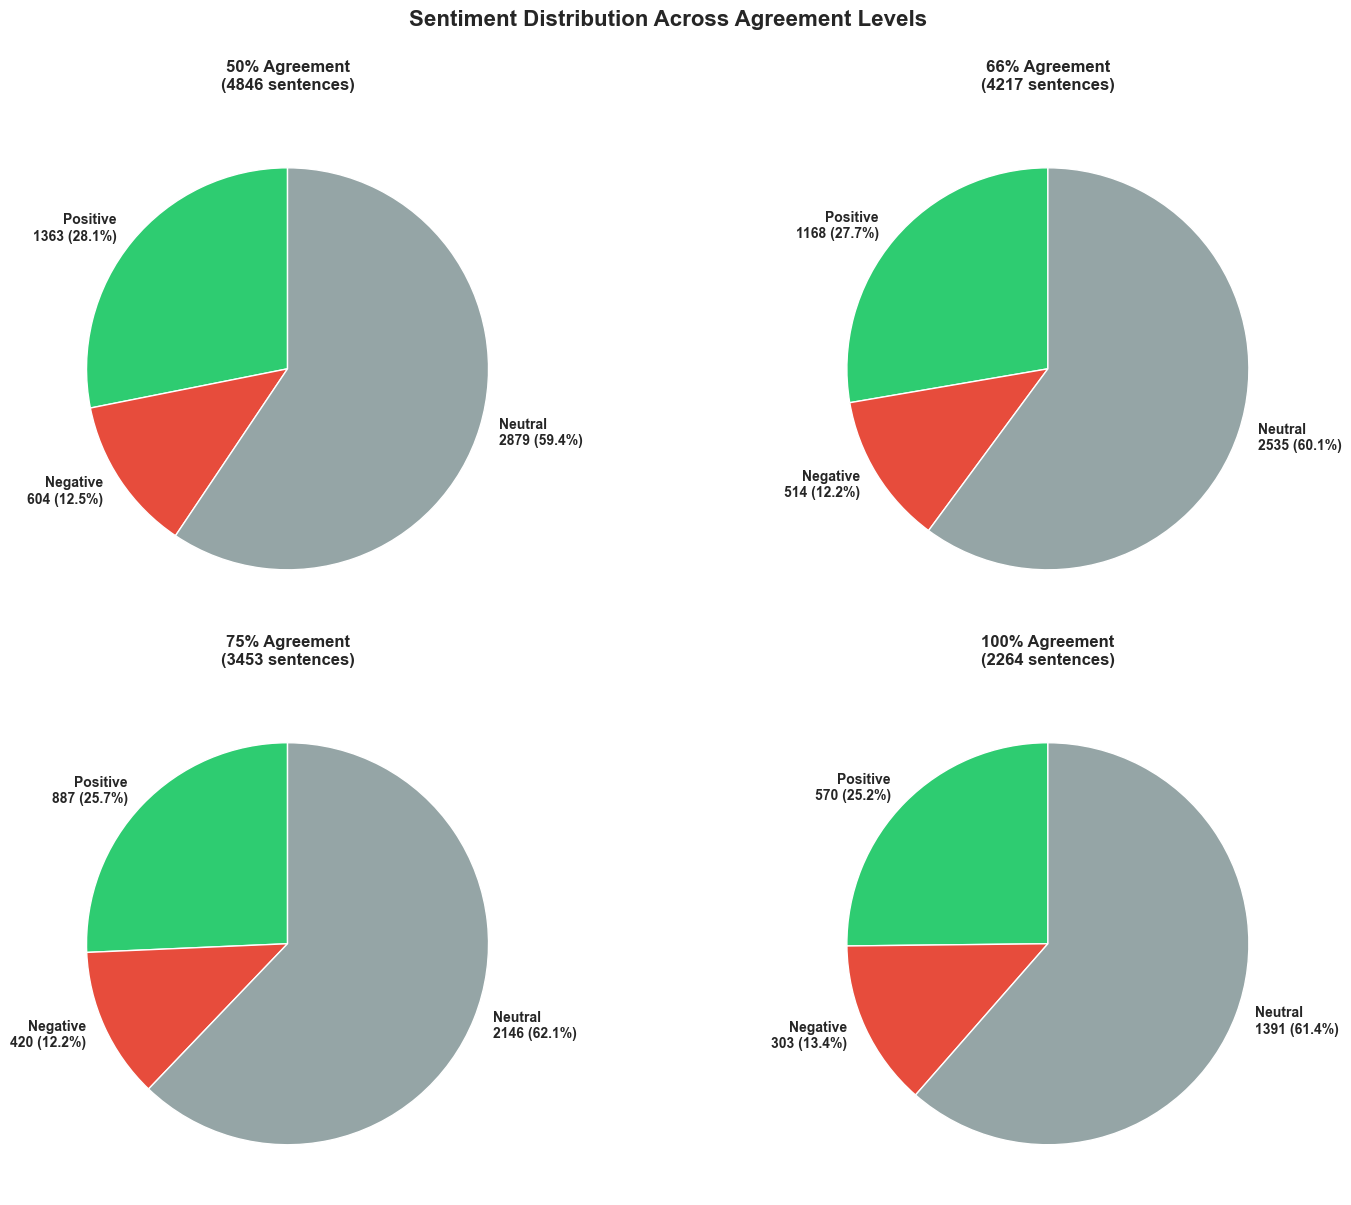

In [6]:
# Visualize sentiment distribution across all datasets
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = ["#2ecc71", "#e74c3c", "#95a5a6"]  # green, red, gray

for idx, (name, df) in enumerate(datasets.items()):
    sentiment_counts = df["sentiment"].value_counts()
    sentiment_counts = sentiment_counts.reindex(["positive", "negative", "neutral"])

    # Create pie chart
    axes[idx].pie(
        sentiment_counts.values,
        labels=[
            f"{s.capitalize()}\n{v} ({v / sentiment_counts.sum() * 100:.1f}%)"
            for s, v in zip(sentiment_counts.index, sentiment_counts.values)
        ],
        colors=colors,
        autopct="",
        startangle=90,
        textprops={"fontsize": 10, "weight": "bold"},
    )
    axes[idx].set_title(
        f"{name}\n({len(df)} sentences)", fontsize=12, weight="bold", pad=20
    )

plt.suptitle(
    "Sentiment Distribution Across Agreement Levels", fontsize=16, weight="bold", y=1.00
)
plt.tight_layout()
plt.savefig("sentiment_distribution_pies.png", dpi=300, bbox_inches="tight")
plt.show()

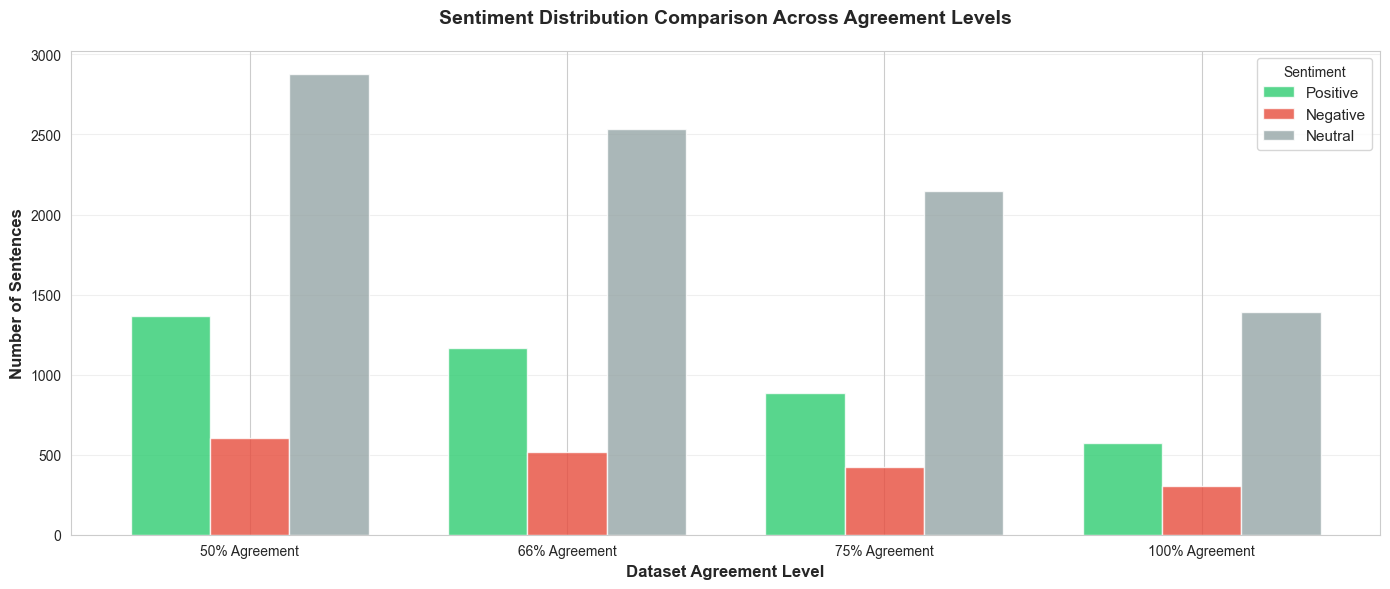

In [7]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(datasets))
width = 0.25

sentiments_list = ["positive", "negative", "neutral"]
sentiment_colors = {"positive": "#2ecc71", "negative": "#e74c3c", "neutral": "#95a5a6"}

for i, sentiment in enumerate(sentiments_list):
    counts = [
        df["sentiment"].value_counts().get(sentiment, 0) for df in datasets.values()
    ]
    ax.bar(
        x + i * width,
        counts,
        width,
        label=sentiment.capitalize(),
        color=sentiment_colors[sentiment],
        alpha=0.8,
    )

ax.set_xlabel("Dataset Agreement Level", fontsize=12, weight="bold")
ax.set_ylabel("Number of Sentences", fontsize=12, weight="bold")
ax.set_title(
    "Sentiment Distribution Comparison Across Agreement Levels",
    fontsize=14,
    weight="bold",
    pad=20,
)
ax.set_xticks(x + width)
ax.set_xticklabels(datasets.keys())
ax.legend(title="Sentiment", fontsize=11)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("sentiment_distribution_bars.png", dpi=300, bbox_inches="tight")
plt.show()

## 4. Class Imbalance Analysis

In [8]:
# Calculate class imbalance ratios
imbalance_data = []

for name, df in datasets.items():
    total = len(df)
    positive = (df["sentiment"] == "positive").sum()
    negative = (df["sentiment"] == "negative").sum()
    neutral = (df["sentiment"] == "neutral").sum()

    imbalance_data.append(
        {
            "Dataset": name,
            "Neutral:Positive Ratio": f"{neutral / positive:.2f}:1",
            "Neutral:Negative Ratio": f"{neutral / negative:.2f}:1",
            "Positive:Negative Ratio": f"{positive / negative:.2f}:1",
            "Majority Class %": f"{(neutral / total) * 100:.2f}%",
        }
    )

imbalance_df = pd.DataFrame(imbalance_data)

print("\n" + "=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)
display(imbalance_df)


CLASS IMBALANCE ANALYSIS


,Dataset,Neutral:Positive Ratio,Neutral:Negative Ratio,Positive:Negative Ratio,Majority Class %
0,50% Agreement,2.11:1,4.77:1,2.26:1,59.41%
1,66% Agreement,2.17:1,4.93:1,2.27:1,60.11%
2,75% Agreement,2.42:1,5.11:1,2.11:1,62.15%
3,100% Agreement,2.44:1,4.59:1,1.88:1,61.44%


## 5. Sentence Length Analysis

In [9]:
# Statistical summary of sentence lengths
length_stats = []

for name, df in datasets.items():
    length_stats.append(
        {
            "Dataset": name,
            "Min Words": df["word_count"].min(),
            "Max Words": df["word_count"].max(),
            "Mean Words": df["word_count"].mean(),
            "Median Words": df["word_count"].median(),
            "Mean Chars": df["char_length"].mean(),
            "Median Chars": df["char_length"].median(),
        }
    )

length_stats_df = pd.DataFrame(length_stats)
length_stats_df = length_stats_df.round(1)

print("\n" + "=" * 80)
print("SENTENCE LENGTH STATISTICS")
print("=" * 80)
display(length_stats_df)


SENTENCE LENGTH STATISTICS


,Dataset,Min Words,Max Words,Mean Words,Median Words,Mean Chars,Median Chars
0,50% Agreement,2,81,23.1,21.0,128.1,119.0
1,66% Agreement,2,81,23.0,21.0,127.2,119.0
2,75% Agreement,2,81,22.8,21.0,124.8,116.0
3,100% Agreement,2,81,22.4,21.0,121.9,111.0


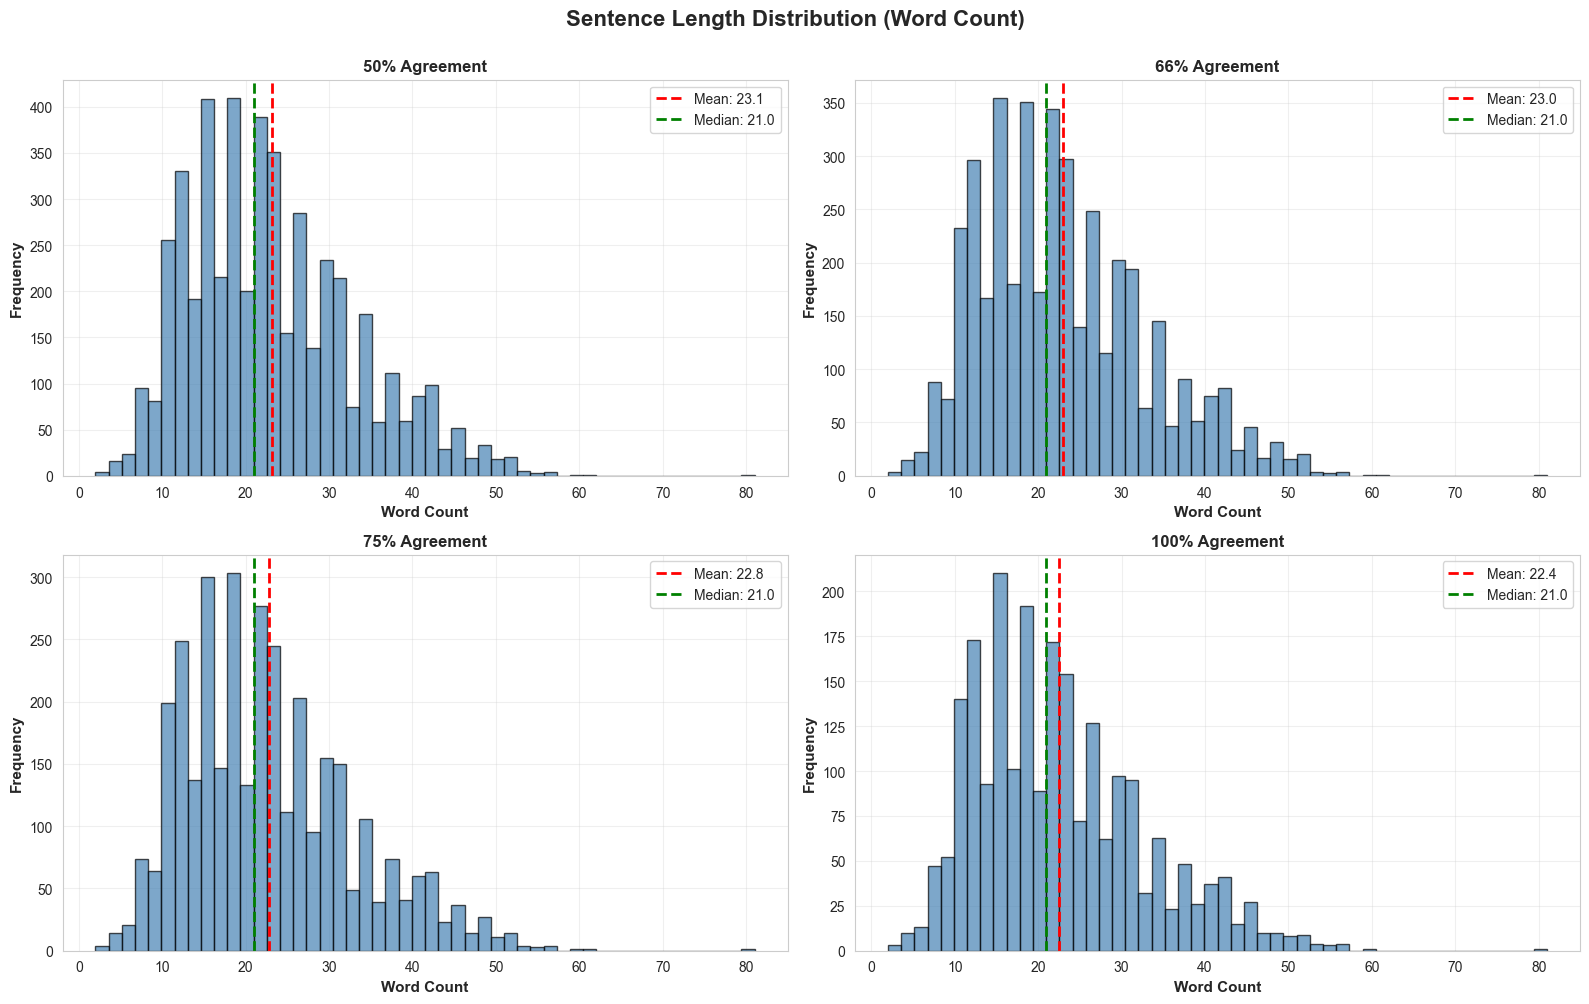

In [10]:
# Visualize sentence length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(datasets.items()):
    axes[idx].hist(
        df["word_count"], bins=50, color="steelblue", alpha=0.7, edgecolor="black"
    )
    axes[idx].axvline(
        df["word_count"].mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {df['word_count'].mean():.1f}",
    )
    axes[idx].axvline(
        df["word_count"].median(),
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Median: {df['word_count'].median():.1f}",
    )
    axes[idx].set_xlabel("Word Count", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(f"{name}", fontsize=12, weight="bold")
    axes[idx].legend(fontsize=10)
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Sentence Length Distribution (Word Count)", fontsize=16, weight="bold", y=1.00
)
plt.tight_layout()
plt.savefig("word_count_histograms.png", dpi=300, bbox_inches="tight")
plt.show()

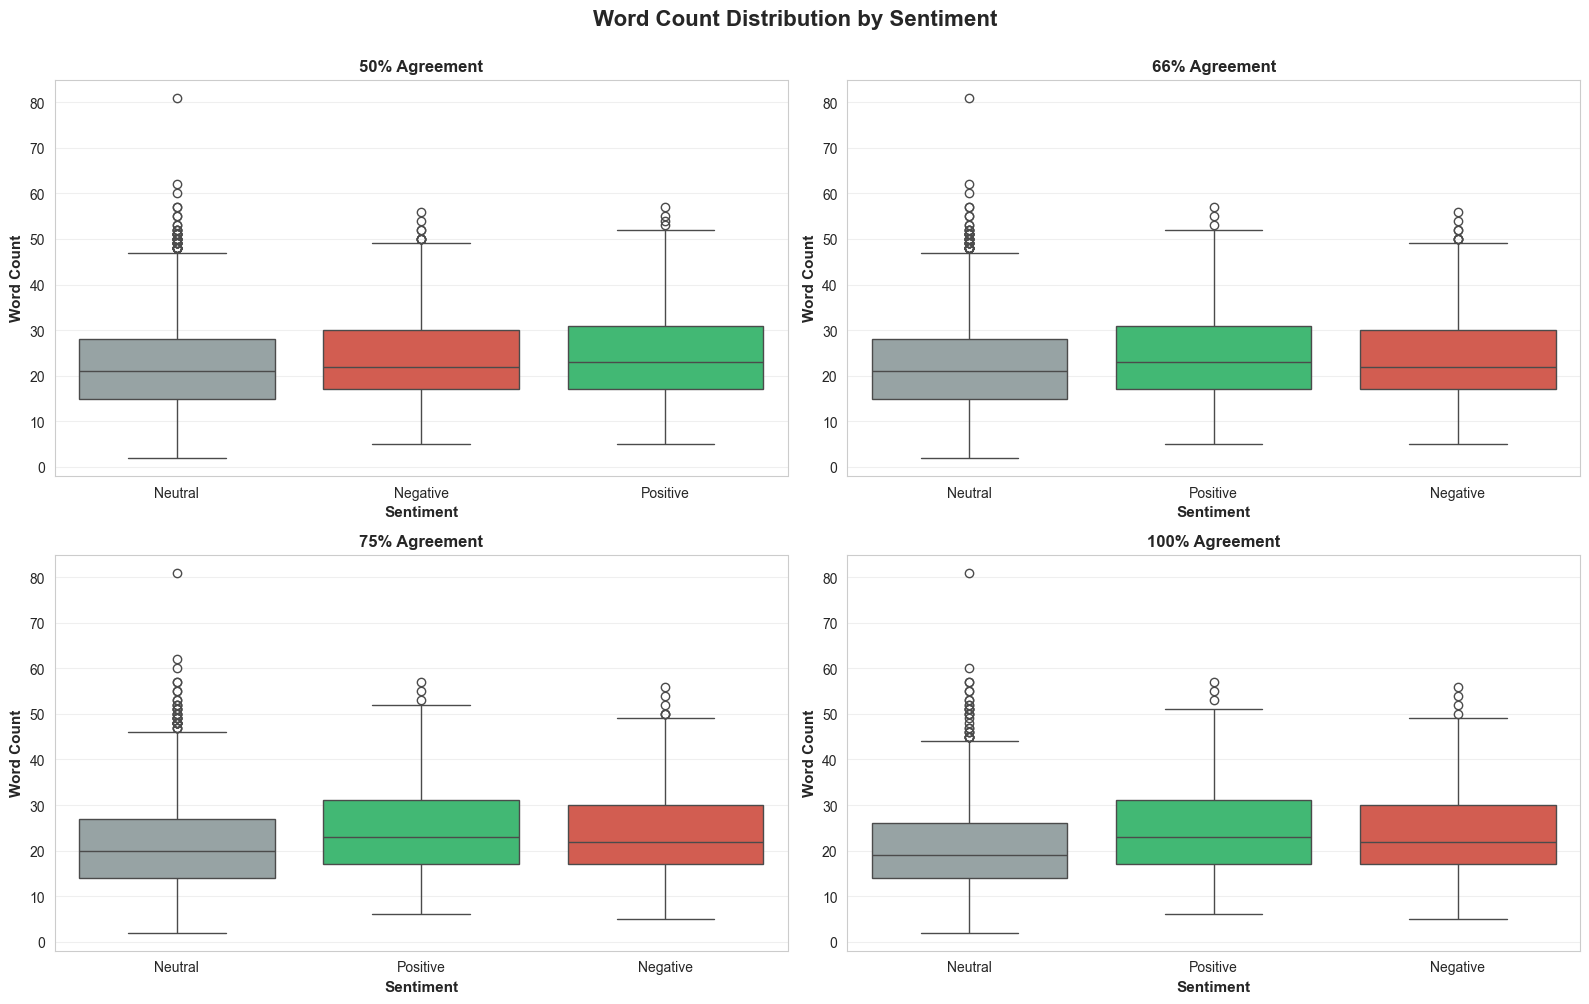

In [11]:
# Box plots for word count by sentiment
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(datasets.items()):
    df_plot = df.copy()
    df_plot["sentiment"] = df_plot["sentiment"].str.capitalize()

    sns.boxplot(
        data=df_plot,
        x="sentiment",
        y="word_count",
        palette={"Positive": "#2ecc71", "Negative": "#e74c3c", "Neutral": "#95a5a6"},
        ax=axes[idx],
    )
    axes[idx].set_xlabel("Sentiment", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Word Count", fontsize=11, weight="bold")
    axes[idx].set_title(f"{name}", fontsize=12, weight="bold")
    axes[idx].grid(axis="y", alpha=0.3)

plt.suptitle("Word Count Distribution by Sentiment", fontsize=16, weight="bold", y=1.00)
plt.tight_layout()
plt.savefig("word_count_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

## 6. Sample Sentences by Sentiment

In [12]:
# Display sample sentences from the 100% agreement dataset
df_samples = datasets["100% Agreement"]

print("\n" + "=" * 80)
print("SAMPLE SENTENCES FROM 100% AGREEMENT DATASET")
print("=" * 80)

for sentiment in ["positive", "negative", "neutral"]:
    print(f"\n{'=' * 80}")
    print(f"{sentiment.upper()} EXAMPLES")
    print(f"{'=' * 80}\n")

    samples = df_samples[df_samples["sentiment"] == sentiment].sample(
        n=min(5, len(df_samples[df_samples["sentiment"] == sentiment])), random_state=42
    )

    for idx, (i, row) in enumerate(samples.iterrows(), 1):
        print(f"{idx}. {row['sentence']}")
        print(f"   [Words: {row['word_count']}, Chars: {row['char_length']}]\n")


SAMPLE SENTENCES FROM 100% AGREEMENT DATASET

POSITIVE EXAMPLES

1. These measures are expected to produce annual cost savings of EUR 1.5 million starting in 2007 .
   [Words: 17, Chars: 96]

2. The last quarter was the best quarter of 2009 in net sales , and the operating margin rose to 12.2 % .
   [Words: 22, Chars: 102]

3. In the fourth quarter of 2009 , Orion 's net profit went up by 33.8 % year-on-year to EUR33m .
   [Words: 20, Chars: 94]

4. Operating profit improved by 44.0 % to ER 4.7 mn from EUR 3.3 mn in 2004 .
   [Words: 17, Chars: 74]

5. Tiimari Latvian representative Ineta Zaharova said that the company earned LVL 122,000 in 2005 profit , which is 20 times more that in 2004 .
   [Words: 25, Chars: 141]


NEGATIVE EXAMPLES

1. Earnings per share ( EPS ) in 2005 decreased to EUR1 .87 from EUR1 .89 in 2003 .
   [Words: 18, Chars: 80]

2. Alma Media 's operating profit amounted to EUR 11.9 mn , down from EUR 15.0 mn a year earlier .
   [Words: 20, Chars: 95]

3. Reported o

## 7. Dataset Comparison: Agreement Level Impact

In [13]:
# Compare how filtering by agreement affects dataset size and distribution
comparison_data = []

base_size = len(datasets["50% Agreement"])

for name, df in datasets.items():
    total = len(df)
    comparison_data.append(
        {
            "Agreement Level": name,
            "Sentences": total,
            "% of 50% Agreement": f"{(total / base_size) * 100:.1f}%",
            "Positive %": f"{(df['sentiment'] == 'positive').sum() / total * 100:.2f}%",
            "Negative %": f"{(df['sentiment'] == 'negative').sum() / total * 100:.2f}%",
            "Neutral %": f"{(df['sentiment'] == 'neutral').sum() / total * 100:.2f}%",
        }
    )

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("IMPACT OF AGREEMENT THRESHOLD ON DATASET")
print("=" * 80)
display(comparison_df)


IMPACT OF AGREEMENT THRESHOLD ON DATASET


,Agreement Level,Sentences,% of 50% Agreement,Positive %,Negative %,Neutral %
0,50% Agreement,4846,100.0%,28.13%,12.46%,59.41%
1,66% Agreement,4217,87.0%,27.70%,12.19%,60.11%
2,75% Agreement,3453,71.3%,25.69%,12.16%,62.15%
3,100% Agreement,2264,46.7%,25.18%,13.38%,61.44%


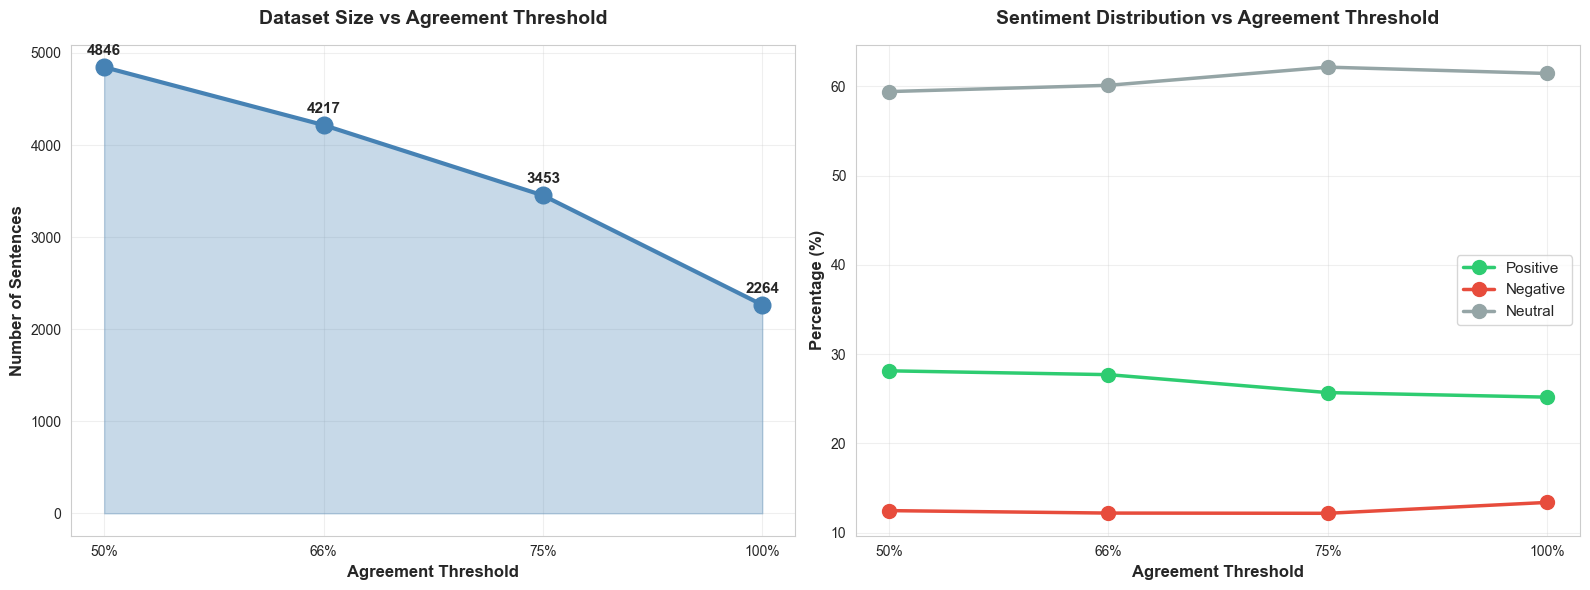

In [14]:
# Line plot showing how dataset size changes with agreement threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Dataset size vs agreement
agreement_levels = ["50%", "66%", "75%", "100%"]
sizes = [len(df) for df in datasets.values()]

ax1.plot(
    agreement_levels, sizes, marker="o", linewidth=3, markersize=12, color="steelblue"
)
ax1.fill_between(range(len(agreement_levels)), sizes, alpha=0.3, color="steelblue")
ax1.set_xlabel("Agreement Threshold", fontsize=12, weight="bold")
ax1.set_ylabel("Number of Sentences", fontsize=12, weight="bold")
ax1.set_title("Dataset Size vs Agreement Threshold", fontsize=14, weight="bold", pad=15)
ax1.grid(alpha=0.3)

# Add value labels
for i, (x, y) in enumerate(zip(agreement_levels, sizes)):
    ax1.text(i, y + 100, str(y), ha="center", va="bottom", fontsize=11, weight="bold")

# Sentiment percentage changes
for sentiment in ["positive", "negative", "neutral"]:
    percentages = [
        (df["sentiment"] == sentiment).sum() / len(df) * 100 for df in datasets.values()
    ]
    color = {"positive": "#2ecc71", "negative": "#e74c3c", "neutral": "#95a5a6"}[
        sentiment
    ]
    ax2.plot(
        agreement_levels,
        percentages,
        marker="o",
        linewidth=2.5,
        markersize=10,
        label=sentiment.capitalize(),
        color=color,
    )

ax2.set_xlabel("Agreement Threshold", fontsize=12, weight="bold")
ax2.set_ylabel("Percentage (%)", fontsize=12, weight="bold")
ax2.set_title(
    "Sentiment Distribution vs Agreement Threshold", fontsize=14, weight="bold", pad=15
)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("agreement_threshold_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. Key Insights and Recommendations

### Key Findings:

1. **Class Imbalance**: All datasets show significant class imbalance with ~60% neutral, ~26-28% positive, and ~12-13% negative sentences

2. **Agreement Impact**: Higher agreement thresholds reduce dataset size by ~50% (from 4,846 to 2,264 sentences) but maintain similar sentiment distributions

3. **Sentence Characteristics**: Average sentence length is ~23 words, with consistent characteristics across sentiment classes

4. **Quality vs Quantity Trade-off**: The 75% agreement dataset offers a good balance with 3,453 sentences and high annotation reliability

### Recommendations:

- **For Training**: Use the 75% or 66% agreement datasets for sufficient training data with good quality
- **For Evaluation**: Use the 100% agreement dataset as a gold standard test set
- **Class Imbalance**: Apply techniques like:
  - Stratified sampling
  - Class weights in loss functions
  - Oversampling minority classes (SMOTE for text)
  - Focal loss for handling imbalance
- **Domain Specificity**: The dataset is focused on Nordic financial news; consider domain adaptation for other markets

## 9. Export Processed Data

In [15]:
# Save processed datasets as CSV for easy access
for name, df in datasets.items():
    filename = name.replace("% ", "pct_").replace(" ", "_").lower() + ".csv"
    df.to_csv(f"processed_{filename}", index=False)
    print(f"Saved: processed_{filename}")

print("\n✓ All processed datasets saved successfully!")

Saved: processed_50pct_agreement.csv
Saved: processed_66pct_agreement.csv
Saved: processed_75pct_agreement.csv
Saved: processed_100pct_agreement.csv

✓ All processed datasets saved successfully!
